# Few-Shot Segmentation

This is the code for our few shot segmentation method. This will work as a tutorial for the method as well

In [1]:
from src.helper import *
from src.model import *
from src.train import *
from src.test import *

Here are the global variables we use for training. Overall they don't change between subject, but could be tuned

In [2]:
## TRAINING CONFIGS
PRECISION = torch.float32 # for smaller memory footprint
LEARNING_RATE = 1e-5 
LR_MAX=1e-5 
LR_MIN=1e-8
WEIGHT_DECAY=0.001
EPOCHS = 100
NUM_WORKERS = 3 # adjust compare to the number of cpu's
BATCH_SIZE_TRAIN = 4 # to stabilize training
BATCH_SIZE_VALID = 4 # to stabilize training
BATCH_SIZE_TEST = 8 # for testing
NUM_TRAIN_SAMPLES = 1000 # number of samples he sees in training
NUM_VALID_SAMPLES = 1000 # number of samples he sees in validation
VALID_EVERY = 10 # valid every nth epoch
CHECKPOINT_EVERY = 25 # we add additionnal checkpoints every nth epoch
INPUT_SHAPE = (5, 96, 96) # shape of filter
TARGET_SHAPE = (3, 96, 96) # shape of targets (must match output)

Here are our configs for each individual subject

In [3]:
## PARAMETER CELL
DO_RESUME = False
ORIENT = "PIL" # orientation of matrix (needs to 
H_IDX = 132 # index to split hemispheres left and right
MASK_THRESH = 50 # threshold used for masking background 
TRAIN_SLICES = np.arange(120, 231, 10) # slices which we use for training
VALID_SLICES = [] # slices which are used for validation
INP_DIR = "../../DATA/HP1/partial_segmentation/" # where to load from
OUT_DIR = "out_HP1/" # where to save to

In [4]:
mkdir(OUT_DIR)
checkpoint_path = OUT_DIR + "/checkpoint.pth.tar"

### Input Data

We reorient the image in the direction in which the traces are made

In [5]:
# input
file = reorient(nib.load(os.path.join(INP_DIR, "img.nii.gz")), orientation=ORIENT) # _unbiased
image, affine = np.clip(file.get_fdata(), 0, 2000).astype(np.float32), file.affine

(<matplotlib.image.AxesImage at 0x7f5a67477690>, (304, 320, 256))

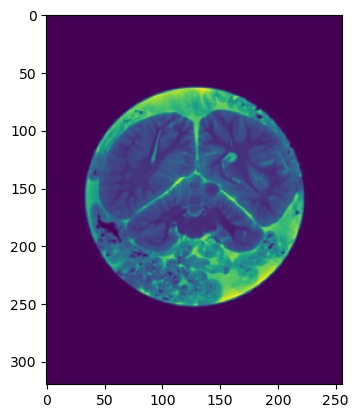

In [8]:
plt.imshow(image[200]), image.shape

Masking is used to find the part of the images which we want to train on. So we will for example make sure to ignore the empty background because it has no information. We will also hide the opposite hemisphere, because we don't want to interfere with it in training. However, we keep the liquid it is submerged in, because we want to be able to differentiate it from the brain. By convention in radiology, left and right are inverted here 

In [9]:
# mask background
mask = (image > MASK_THRESH).astype(bool)

In [10]:
# other half mask 
right_mask = mask.copy()
right_mask[:, :, H_IDX:] = 0 # take half

In [11]:
# Half mask 
left_mask = mask.copy()
left_mask[:, :, :H_IDX] = 0 # take half

In [12]:
image = standardize_image(image, mask) # standardization takes significant time, but probably worth it
train_mask = right_mask # be careful, this is the side we train on which by fault is the right side

(<matplotlib.image.AxesImage at 0x7f5a65b71ed0>,
 (304, 320, 256),
 (304, 320, 256))

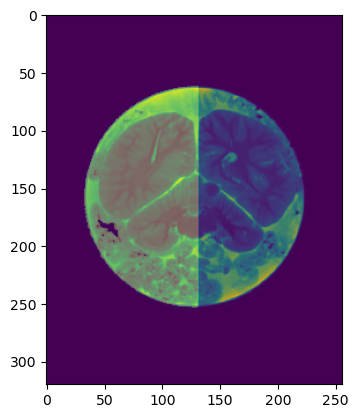

In [14]:
i = 200
plt.imshow(image[i])
plt.imshow(train_mask[i], alpha=0.3), image.shape, right_mask.shape

We load our labels, by convention the brain mask is the last label!

In [15]:
# targets
target_labels = ["gm", "wm"] # 
target_path = ["gm.nii.gz", "wm.nii.gz"] # 
target = [reorient(nib.load(os.path.join(INP_DIR, p)), orientation=ORIENT).get_fdata() for p in target_path]

In [16]:
# brain mask
brain_mask = np.clip(np.array(target).sum(axis=0), 0, 1) # brain mask is sum of everything
target = np.clip(np.array(target + [brain_mask]), 0, 1) # add to target
target_labels.append("brain") # add to list

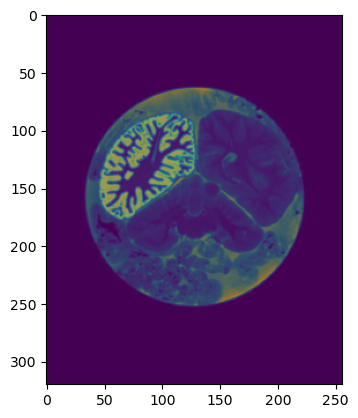

In [18]:
i = 200
plt.imshow(image[i])
plt.imshow(target[0, i], alpha=0.5)

### Slicing

We will only have certain slices which have been manually annotated, so we will keep training constrained to those slices. Additionally, a part of the slices can be used for validation

In [19]:
counts = target[:-1].sum(axis=0, dtype=np.float32) + train_mask # we add total exterior mask

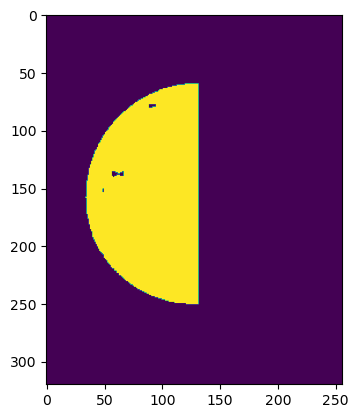

In [20]:
plt.imshow(counts[100])

In [21]:
# get all indice which have annotations
x, y, z = indices = np.array(np.where(counts > 0))
slices = np.unique(x) # all the slice which have an index
slices

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

In [22]:
## indices
train_indices = indices.T[np.isin(x, TRAIN_SLICES)]
valid_indices = indices.T[np.isin(x, VALID_SLICES)]
print("training examples:", len(train_indices), ", validation examples: ", len(valid_indices))

training examples: 180007 , validation examples:  0


In [23]:
TRAIN_SLICES

array([120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230])

### Weighting

We use the weighting to find where the most information is contained

In [24]:
weight_matrix = (conv_weight(counts, TRAIN_SLICES, TARGET_SHAPE) * train_mask) + train_mask

(<matplotlib.image.AxesImage at 0x7f5a64e43cd0>, 14593.7705, 0.0)

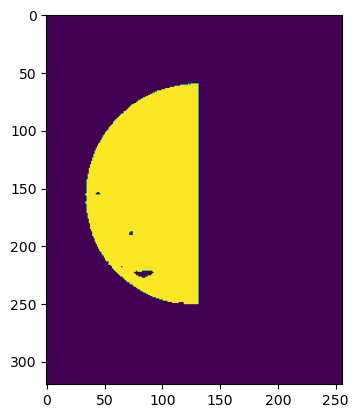

In [25]:
plt.imshow(weight_matrix[122]), weight_matrix.max(), weight_matrix.min()

In [26]:
# we only take the weights which are in our training slices
weights = np.array([weight_matrix[tuple(idx)] for idx in indices.T])
train_weights = weights.T[np.isin(x, TRAIN_SLICES)]
valid_weights = weights.T[np.isin(x, VALID_SLICES)]

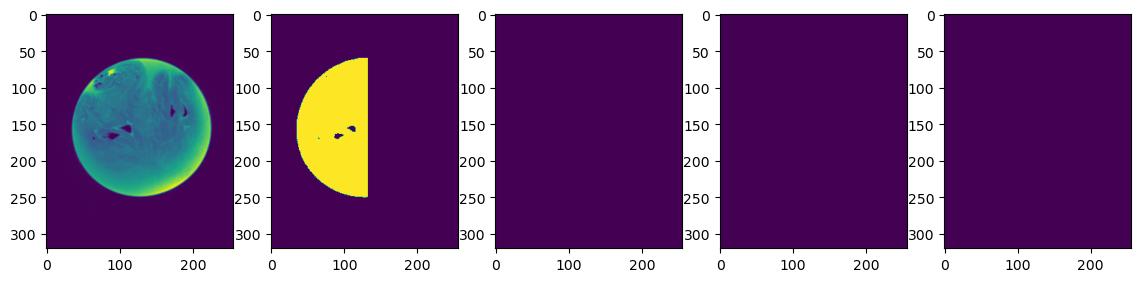

In [27]:
fig, axs = plt.subplots(1, len(target) + 2, figsize=(14, 6))
i = 82
axs[0].imshow(image[i])
axs[1].imshow(train_mask[i])
for j in range(len(target)):
    axs[j+2].imshow(target[j][i])

In [28]:
label_count = target.sum(axis=(1, 2, 3))
label_prevalence =  label_count.sum() / label_count
alpha = len(target_labels) * (label_prevalence / label_prevalence.sum()) # we constraint to sum to be the number of voxel
print(alpha, target_labels)

[1.077 1.328 0.595] ['gm', 'wm', 'brain']


### Dataset

We now create our custom dataset, which include data standardization and augmentation

In [29]:
class BrainDataset(Dataset):
    def __init__(self, indices, image, mask, targets=None, test=False):
        self.indices = indices # list of coordinates in volume (x, y, z) 
        
        self.image = image
        self.targets = targets
        self.mask = mask

        self.input_shape = INPUT_SHAPE
        self.target_shape = TARGET_SHAPE
        self.test = test # test time or not?
        

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        (d, w, h) = self.target_shape
        
        # get index
        idx = self.indices[idx]
        
        if self.test:

            # get the window
            img = torch.tensor(
                get_window(idx, self.image, self.input_shape),
            dtype=PRECISION)

            # get mask
            m = torch.tensor(get_window(idx, self.mask, (1, w, h))[0], dtype=PRECISION)
            mask  = torch.stack([m] * d)
            
            # just return the image
            return torch.unsqueeze(img, 0), torch.unsqueeze(mask, 0), tuple(idx)

        else:
            # we add a random rotation
            angle = 0
            if random.randint(0, 100) <= 25: 
                angle = random.randint(-20, 20) # this is a plausible range which Richard used
                
            img = torch.tensor(
                inplace_rotation(idx, self.image, self.input_shape, angle),
            dtype=PRECISION)
            
            target = torch.stack([
                torch.tensor(inplace_rotation(idx, targ, (1, w, h), angle)[0], dtype=PRECISION)
            for i, targ in enumerate(self.targets)])

            m = torch.tensor(inplace_rotation(idx, self.mask, (1, w, h), angle)[0], dtype=PRECISION)
            mask  = torch.stack([m] * d)
            
            
            # we add a random bias field
            if random.randint(0, 100) <= 0:
                bias = tio.transforms.RandomBiasField(0.2)
                img = bias(torch.unsqueeze(img, 0)).squeeze(0)

            # we add randomly noise
            if random.randint(0, 100) <= 25:
                noise = tio.transforms.RandomNoise()
                img = noise(torch.unsqueeze(img, 0)).squeeze(0)
            
            # flip left-right
            if random.choice([0, 1]):
                img = torch.flip(img, dims=(-1,))
                target = torch.flip(target, dims=(-1,))
                mask = torch.flip(mask, dims=(-1,))

            # we also flip posterior-anterior
            if random.choice([0, 1]):
                img = torch.flip(img, dims=(0,))

            # we randomly scale and move intensity around to help with training
            shift = np.random.normal(0, 0.5, 1).astype(np.float32)
            scale = np.random.normal(1, 0.2, 1).astype(np.float32)
            img = (img * scale) + shift
            
            return torch.unsqueeze(img, 0), torch.unsqueeze(target, 0), torch.unsqueeze(mask, 0) # we have a single target slice

In [30]:
train_set = BrainDataset(train_indices, image, train_mask, target, test=False)
valid_set = BrainDataset(valid_indices, image, train_mask, target, test=False)

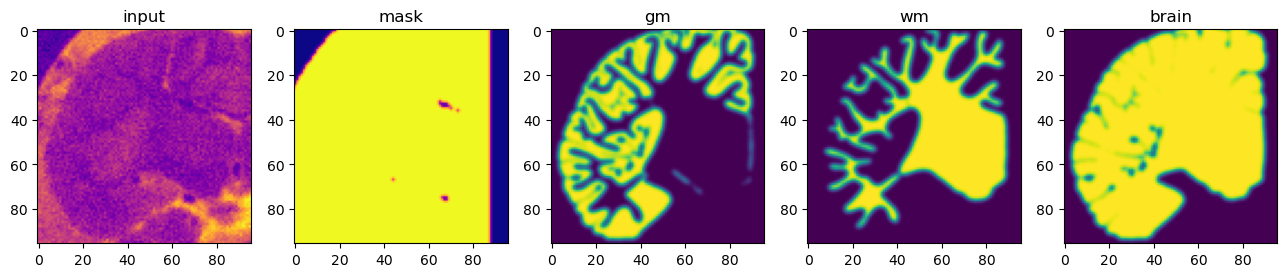

In [35]:
img, out, m = train_set[np.random.randint(len(train_indices))]
fig, axs = plt.subplots(1, len(target)+2, figsize=(16, 4))
i = 2
axs[0].imshow(img[0][i], cmap="plasma"), axs[0].set_title("input")
axs[1].imshow(m[0][i], cmap="plasma"), axs[1].set_title("mask")
for j in range(len(target)):
    axs[j+2].imshow(out[0][j], vmin=0) 
    axs[j+2].set_title(target_labels[j])

### Dataloader

In our training dataloader, we sample our training by the weights, the validation dataloader just generates the dice coefficient by applying the model

In [36]:
# sampler
train_sampler = WeightedRandomSampler(train_weights, NUM_TRAIN_SAMPLES, replacement=True)
valid_sampler = WeightedRandomSampler(valid_weights, NUM_VALID_SAMPLES, replacement=True)

In [37]:
# loader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, num_workers=NUM_WORKERS, 
                          sampler=train_sampler, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE_VALID, num_workers=NUM_WORKERS, 
                          sampler=valid_sampler, pin_memory=True, drop_last=True)

(<matplotlib.image.AxesImage at 0x7f5a9685bed0>,
 <matplotlib.image.AxesImage at 0x7f5a96731550>)

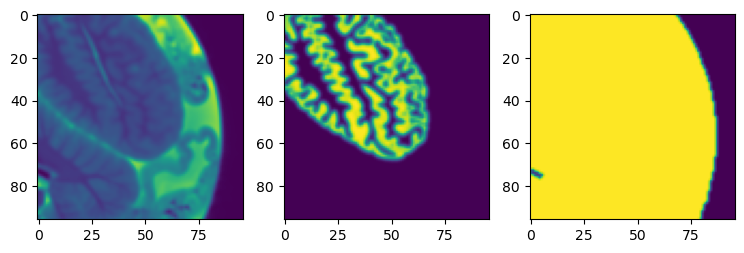

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
x, y, m = next(iter(train_loader))
axs[0].imshow(x[i, 0, 2]), axs[1].imshow(y[i, 0, 0], vmin=0, vmax=1), axs[2].imshow(m[i, 0, 0], vmin=0, vmax=1)

## Training

In [46]:
# TRAINING
def train_loop(model, loader, device):
    
    global x, y, m, prediction, loss
    
    model.train()
    
    # trackings
    losses = []
    #schedule = CosineAnnealingLR(model.optimizer, T_max=len(train_loader), eta_min=LR_MIN)
    
    # loop over the train load
    #for batch, (x, y, m) in enumerate(loader):
    pbar = tqdm(loader, desc="Train  : ")
    for batch in pbar:
        x, y, m = batch
        
        # setting gradient to zero
        model.optimizer.zero_grad()
        
        # load to model
        x = x.to(device)
        y = y.to(device)
        m = m.to(device)
        
        # prediction
        prediction = model(x)
        loss = (model.loss_function(prediction, y) * m).sum()
        
        # backpropagation
        loss.backward()
        #print(int(loss.item()), int(torch.nn.utils.clip_grad_norm(model.parameters(), 1000).item())) #, schedule.get_last_lr())
        model.optimizer.step()
        
        # track
        #print("loss = {:.2f}".format(loss.item()))
        losses.append(loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.2f}"})

    pbar.close()  # close bar
    return np.mean(losses)

In [47]:
# VALIDATION
def valid_loop(model, loader, device):
    model.eval()
    
    # trackings
    losses = []
    
    # loop over the train load
    with torch.no_grad():
        #for batch, (x, y, m) in enumerate(loader):
        pbar = tqdm(loader, desc="Valid  : ")
        
        for batch in pbar:
            x, y, m = batch
            
            # load to model
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            
            # prediction
            prediction = model(x)
            loss = (model.loss_function(prediction, y) * m).sum()
            
            # track
            #print("loss = {:.2f}".format(loss.item()))
            losses.append(loss.item())
            pbar.set_postfix({'loss': f"{loss.item():.2f}"})
        
        pbar.close()  # close bar
    return np.mean(losses)

In [48]:
# run model over the whole image
def apply_model(model, image, mask, stride=32):
    c, w, h = TARGET_SHAPE # shape of target
    sx, sy, sz = np.array(TARGET_SHAPE) // 2 # half of shape of targets
    
    # get indices
    test_indices = grid_indices(mask, stride=(1, stride, stride), filters=INPUT_SHAPE) # we use a grid because we want uniform repartition
    
    # generate dataset and dataloader
    test_set = BrainDataset(test_indices, image, mask, test=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_TEST, 
                             num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # we run the model now over those points
    sum_img = np.zeros((c,) + image.shape, dtype=np.float32) # shape: (c, D, W, H)
    count_img = np.zeros((c,) + image.shape, dtype=np.float32) # shape: (c, D, W, H)
    
    for idx, (inp, m, coor) in enumerate(test_loader):
            
        # load data
        inp = inp.to(device)

        # make prediction
        pred = model(inp).sigmoid() # we apply a sigmoid 
        pred = (pred.detach().cpu() * m).numpy() # and mask
        xs, ys, zs = coor

        # loop over items in batch
        for i in range(pred.shape[0]):

            # position
            val = pred[i, 0] # has shape of target
            x, y, z = xs[i], ys[i], zs[i]

            # sum
            sum_img[:, x, y-sy:y+sy, z-sz:z+sz] += val 
            count_img[:, x, y-sy:y+sy, z-sz:z+sz] += np.ones_like(val)
            
    # average product
    return np.divide(sum_img, count_img, where=(count_img != 0))

In [49]:
# CHECKPOINTING
def checkpoint(model, image, mask, epoch, target=None):
    
    # we apply the model to the whole brain
    prediction = apply_model(model, image, mask)
    binary_prediction = (prediction >= 0.5)
    
    # and get stats which we update
    metrics = {}
    if target is not None:
        for i, label in enumerate(target_labels):
            metrics.update(get_stats(binary_prediction[i], target[i],  mask=mask, 
                                     path="/Validation", label=label))
    
    # we also save prediction
    for i, label in enumerate(target_labels):
        save_img(prediction[i], OUT_DIR + "/last_pred", label, affine)
        
    return metrics

In [50]:
def run(model, train_loader, valid_loader, mask, epochs=100, resume=False):
    
    # load checkpoint if possible
    if resume is True:
        start_epoch = load_checkpoint(model, checkpoint_path, device=device) + 1
    else:
        start_epoch = 1
    
    # run
    tracker = SummaryWriter(log_dir=OUT_DIR+"/runs/")
    
    for epoch in tqdm(range(start_epoch, epochs+1), desc="Epoch : "):
        
        loss = train_loop(model, train_loader, device=device)
        tracker.add_scalar('Loss/train', loss, epoch)
        
        if (epoch % VALID_EVERY) == 0:
            if len(valid_set) > 0:
                loss = valid_loop(model, valid_loader, device=device)
                tracker.add_scalar('Loss/valid', loss, epoch)
            
        if (epoch % CHECKPOINT_EVERY) == 0:
            print("CHECKPOINT {}".format(epoch))

            # calculate validation metrics -> skip
            '''metrics = checkpoint(model, image, mask, epoch, target)
            for k, m in metrics.items():
                tracker.add_scalar(k, m, epoch)
                print("{}: {}".format(k, m))'''

            # save checkpoint
            save_checkpoint(model, epoch, checkpoint_path)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [52]:
model = UNET_3D_to_2D(0, channels_in=1, channels=32, 
                     growth_rate=8, dilated_layers=[4,4,4,4], 
                     output_channels=len(target_labels)).to(device).float() # len(target)

In [53]:
model.loss_function = BCE_from_logits_focal(2)
model.optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
#load_checkpoint(model, checkpoint_path, device)
run(model, train_loader, valid_loader, mask, epochs=EPOCHS, resume=DO_RESUME)

In [40]:
#save_checkpoint(model, 25, checkpoint_path)

## Apply Model

Here we generate the 3D segmentation of the image

In [177]:
#load_checkpoint(model, checkpoint_path, device)

In [178]:
# all prediction
prediction_right = apply_model(model, image, mask, stride=32)

In [ ]:
# we do the symmetric not just for robustness but also because of starting point
prediction_left = np.flip(apply_model(model, np.flip(image, -1), np.flip(mask, -1), stride=32), -1)

In [ ]:
prediction = (prediction_left + prediction_right) / 2
#prediction[-1] = np.max([prediction_left[-1], prediction_right[-1]], axis=0)

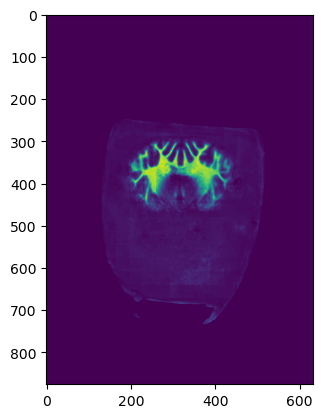

In [198]:
plt.imshow((prediction)[1, 70], vmax=1, vmin=0)

In [199]:
seg_img = post_processing(image, prediction, OUT_DIR, left_mask=left_mask, right_mask=right_mask, affine=affine)

Found Hemispherical Mask


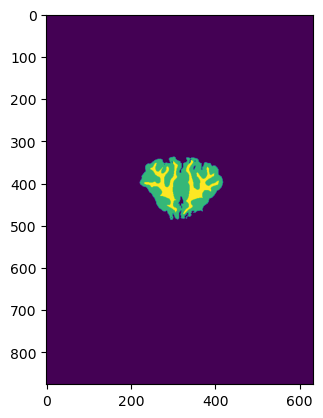

In [210]:
plt.imshow((seg_img)[30])

## Zero-Shot

We use the pre-trained model to apply to new examples to get measurements